# Santa Clara Winery Dataset

Santa Clara Winery es un viñedo fundado en 1881 por la familia Miller, que a través de varias generaciones se ha dedicado a producir algunas de las variedades de Cabernet Sauvignon y Pinot Noir más reconocidas en California. El viñedo cuenta con una base de datos de calidad del vino que contiene información sobre los vinos producidos en el norte de California y sus variables fisicoquímicas, como la acidez, el ácido cítrico, el azúcar residual, los cloruros, entre otras, así como la calidad del vino, medida del 0 al 10. Usted ha sido contratado por el viñedo para generar un modelo predictivo que permita estimar la calidad del vino en base a sus variables fisicoquímicas. Esto le permitirá al viñedo probar nuevos procesos de producción del vino teniendo un estimado a piriori de la calidad del vino en función de sus valores fisicoquímicos.

La base de datos contiene la siguiente información de cada vino:

|     Variables de entrada (basadas en pruebas fisioquímicas)    ||
|:-----------:|:---------|
|      1     | Acidez fija   |
|      2     | Acidez volátil   |
|      3     | Ácido cítrico   |
|      4     | Azucar residual   |
|      5     | Cloruros   |
|      6     | Dióxido de azufre libre |
|      7     | Dióxido de azufre total |
|      8     | Densidad |
|      9     | pH |
|     10     | Sulfatos |
|     11     | Alcohol |
|     Variables de salida (basada en datos sensoriales)    ||
|     12     | Calidad (puntuación entre 0 y 10) |

CAMBIAR URL
[descargar dataset](https://drive.google.com/uc?export=download&id=1AKTS-Z-1WN0Wrn-s5cyCXk2ccgQTkJTz)

## Configuraciones iniciales

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."

## Cargando el dataset

In [2]:
import pandas as pd

wine_df = pd.read_csv(os.path.join(PROJECT_ROOT_DIR, 'wines.csv'))
# Obteniendo los tipos de datos de las propiedades
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


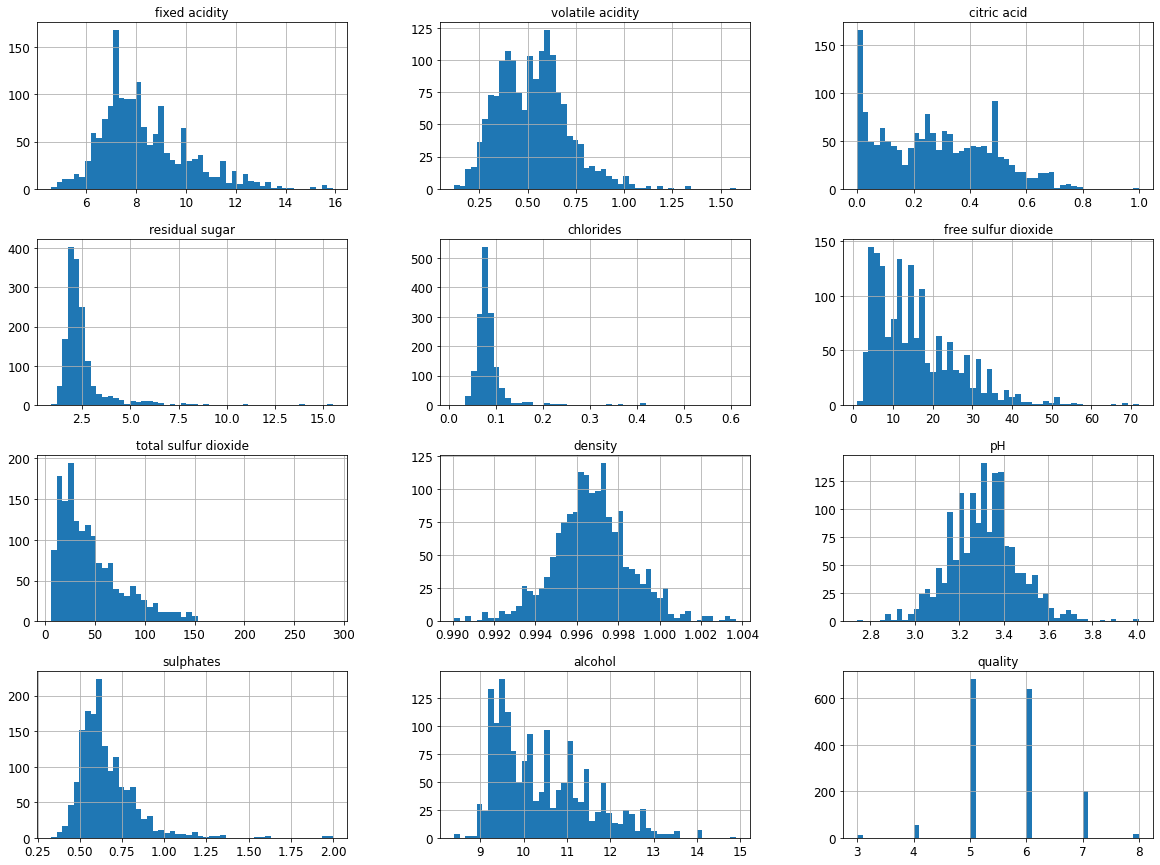

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
wine_df.hist(bins=50, figsize=(20,15))
plt.show()

Se puede observar en la gráfica de título "quality" que la muestra se encuentra sesgada, debido a que la cantidad de datos por clase de calidad no tiene una distribución equitativa. Es decir, que la cantidad es bastante pobre en el caso de las calidades: 3, 4 y 8. Por lo que esto puede afectar a la efectividad de los modelos.

In [4]:
# Tamaño del dataset
wine_df.shape

(1599, 12)

In [5]:
# Verificar si hay algún valor nulo
wine_df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

# Estableciendo la correlación de las propiedades

In [6]:
corr_matrix = wine_df.corr()
corr_matrix["quality"].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64

## Mapa de calor de las correlaciones

<AxesSubplot:>

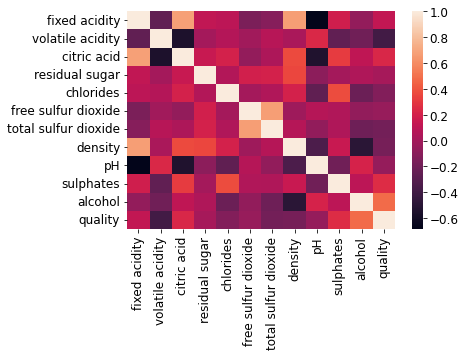

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(corr_matrix)

# Separando los datos para entrenamiento y pruebas

Obteniendo la columna de clases

In [8]:
wine_Y = wine_df['quality']
wine_df.drop('quality', axis=1, inplace=True)
# Getting the possible classes
list(set(wine_Y))

[3, 4, 5, 6, 7, 8]

Como se pude observar, este problema es de clasificación. Se procede a estratificar y separar los datos, debido a la poca cantidad de datos, te toma solo un 10% de estos para el conjunto de pruebas:

In [9]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit

imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(wine_df) # Getting the column medians and filling the null values with the median for each column
X_df = pd.DataFrame(X, columns=wine_df.columns, index=wine_df.index)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(X_df, wine_Y):
    X_train, X_test = wine_df.loc[train_index], wine_df.loc[test_index]
    y_train, y_test = wine_Y.loc[train_index], wine_Y.loc[test_index]

# Entrenamiento de los modelos

Los modelos a entrenar son los siguientes:
1. SGDClassifier
2. SVC con kernel polinomial de grado 3
3. SVC con kernel polinomial de grado 5
4. SVC con kernel RBF
5. OneVsRestClassifier
6. DecisionTree
7. RandomForest
8. KnnClassifier

Se quiere probar como se comportan estos modelos con el dataset para luego poder realizar otras acciones con los mejores.

### Validación Cruzada
Datos obtenidos a partir de la validación cruzada
- `Scores`: Matriz de puntuaciones del estimador para cada ejecución de la validación cruzada.
- `Mean Scores`: Media de las puntuaciones del estimador para cada ejecución de la validación cruzada. (Con esto se puede saber la precisión del modelo)
- `Mean Absolute Error`: Media de la diferencia absoluta entre el valor real y el valor estimado.
- `Mean Squared Error`: Media de la diferencia cuadrática entre el valor real y el valor estimado.
- `Root Mean Squared Error`: Raíz de la media de la diferencia cuadrática entre el valor real y el valor estimado.
- `R2 Score`: Puntuación de la calidad del modelo.
- `Standard Deviation`: Desviación estándar de los datos.
- `Intercept`: Valor de la pendiente de la recta.

A estos valores se le suma: precision, recall y la puntuación F1. Esto para ver que tan bien funciona cada clasificador

In [10]:
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    precision_score, 
    recall_score
) 
from sklearn.model_selection import cross_val_score, cross_val_predict

average_value = 'weighted' # Esto debido al sesgo dentro de los datos

def display_scores(model, scores, y_train, y_pred):
    print("Scores:", scores)
    print("Mean Scores:", scores.mean())
    print("Accuracy:", round(scores.mean()*100,2), "%")
    print("Mean Absolute Error:", mean_absolute_error(y_train, y_pred))
    print("Mean Squared Error:", mean_squared_error(y_train, y_pred))
    print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_train, y_pred)))
    print("R2 Score:", r2_score(y_train, y_pred))
    print("Standar Deviation:", scores.std())
    print('-'*25)
    print("Precision: ", precision_score(y_train, y_pred, average=average_value))
    print("Recall: ", recall_score(y_train, y_pred, average=average_value))
    print("F1 Score: ", f1_score(y_train, y_pred, average=average_value))
    try:
        print("Intercept", model.intercept_)
    except:
        pass

### Matriz de confusión

Esta matriz permite ver los posibles errores que cometen los modelos en la clasificación de los datos.

In [11]:
# Librerias necesarias para la matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### SGDClassifier

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

sgdc_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("sgdc_clf", SGDClassifier(max_iter=5000, alpha=0.01))
    ])
sgdc_clf.fit(X_train, y_train)

sgdc_scores = cross_val_score(sgdc_clf, X_train, y_train, cv=5)
sgdc_scores_predicted = cross_val_predict(sgdc_clf, X_train, y_train, cv=5)
display_scores(sgdc_clf, sgdc_scores, y_train, sgdc_scores_predicted)

Scores: [0.56597222 0.54513889 0.54861111 0.56597222 0.53310105]
Mean Scores: 0.5517590979481224
Accuracy: 55.18 %
Mean Absolute Error: 0.4954829742876998
Mean Squared Error: 0.5969423210562891
Root Mean Squared Error: 0.7726204249541226
R2 Score: 0.08369495762064805
Standar Deviation: 0.012695556081866578
-------------------------
Precision:  0.4676452558079046
Recall:  0.5538568450312717
F1 Score:  0.4902744901181055


C:\Users\gameo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


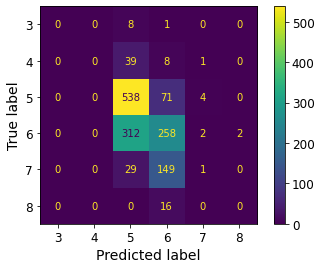

In [13]:
conf_matrix = confusion_matrix(y_train, sgdc_scores_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=sgdc_clf.classes_)
disp.plot()
plt.show()

### SVC con kernel polinomial grado 3

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

poly3_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("poly_clf", SVC(C=0.1, kernel='poly', gamma=2, degree=3, coef0=0.1))
    ])
poly3_kernel_svm_clf.fit(X_train, y_train) # Para obtener el atributo classes_

poly3_scores = cross_val_score(poly3_kernel_svm_clf, X_train, y_train, cv=5)
poly3_scores_predicted = cross_val_predict(poly3_kernel_svm_clf, X_train, y_train, cv=5)
display_scores(poly3_kernel_svm_clf, poly3_scores, y_train, poly3_scores_predicted)

Scores: [0.58333333 0.60416667 0.5625     0.55208333 0.55400697]
Mean Scores: 0.5712180603948898
Accuracy: 57.12 %
Mean Absolute Error: 0.5079916608756081
Mean Squared Error: 0.684503127171647
Root Mean Squared Error: 0.8273470415561096
R2 Score: -0.05071067141287733
Standar Deviation: 0.019853234143341062
-------------------------
Precision:  0.5802824607924775
Recall:  0.5712300208478109
F1 Score:  0.5752219012389921


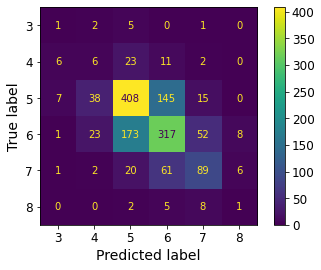

In [15]:
conf_matrix = confusion_matrix(y_train, poly3_scores_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=poly3_kernel_svm_clf.classes_)
disp.plot()
plt.show()

### SVC con kernel polinomial grado 5

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

poly5_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("poly_clf", SVC(C=0.01, kernel='poly', gamma=2, degree=5, coef0=0.1))
    ])
poly5_kernel_svm_clf.fit(X_train, y_train) # Para obtener el atributo classes_

poly5_scores = cross_val_score(poly5_kernel_svm_clf, X_train, y_train, cv=5)
poly5_scores_predicted = cross_val_predict(poly5_kernel_svm_clf, X_train, y_train, cv=5)
display_scores(poly5_kernel_svm_clf, poly5_scores, y_train, poly5_scores_predicted)

Scores: [0.5625     0.64583333 0.61458333 0.60069444 0.51567944]
Mean Scores: 0.5878581107239645
Accuracy: 58.79 %
Mean Absolute Error: 0.5121612230715775
Mean Squared Error: 0.7512161223071577
Root Mean Squared Error: 0.8667272479316418
R2 Score: -0.15311496020032522
Standar Deviation: 0.04492867536067861
-------------------------
Precision:  0.5994812548331185
Recall:  0.5879082696316886
F1 Score:  0.5930700734717104


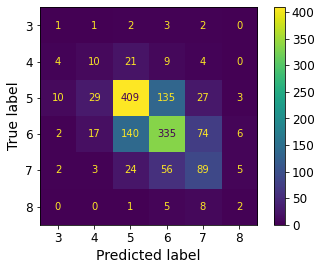

In [17]:
conf_matrix = confusion_matrix(y_train, poly5_scores_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=poly5_kernel_svm_clf.classes_)
disp.plot()
plt.show()

### SVC with RBF kernel

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("rbf_clf", SVC(C=100, kernel='rbf', gamma=0.01))
    ])
rbf_kernel_svm_clf.fit(X_train, y_train) # Para obtener el atributo classes_

rbf_scores = cross_val_score(rbf_kernel_svm_clf, X_train, y_train, cv=5)
rbf_scores_predicted = cross_val_predict(rbf_kernel_svm_clf, X_train, y_train, cv=5)
display_scores(rbf_kernel_svm_clf, rbf_scores, y_train, rbf_scores_predicted)

Scores: [0.61805556 0.56944444 0.57291667 0.61805556 0.61324042]
Mean Scores: 0.5983425280681378
Accuracy: 59.83 %
Mean Absolute Error: 0.4440583738707436
Mean Squared Error: 0.5343988881167477
Root Mean Squared Error: 0.7310259148051783
R2 Score: 0.1796989783588805
Standar Deviation: 0.022274324674476074
-------------------------
Precision:  0.5682587352807775
Recall:  0.5983321751216122
F1 Score:  0.5770880027556436


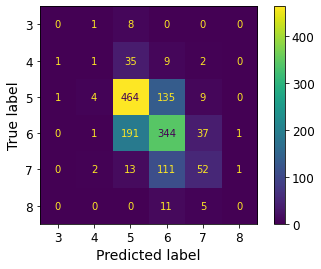

In [19]:
conf_matrix = confusion_matrix(y_train, rbf_scores_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rbf_kernel_svm_clf.classes_)
disp.plot()
plt.show()

### OneVsRestClassifier

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("ovr_clf", OneVsRestClassifier(SVC(gamma="auto")))
    ])
ovr_clf.fit(X_train, y_train) # Para obtener el atributo classes_

ovr_scores = cross_val_score(ovr_clf, X_train, y_train, cv=5)
ovr_scores_predicted = cross_val_predict(ovr_clf, X_train, y_train, cv=5)
display_scores(ovr_clf, ovr_scores, y_train, ovr_scores_predicted)

Scores: [0.61458333 0.56944444 0.60069444 0.65277778 0.62369338]
Mean Scores: 0.6122386759581881
Accuracy: 61.22 %
Mean Absolute Error: 0.4225156358582349
Mean Squared Error: 0.4947880472550382
Root Mean Squared Error: 0.7034117195889177
R2 Score: 0.24050152482642773
Standar Deviation: 0.027366921516812106
-------------------------
Precision:  0.5794295441422637
Recall:  0.6122307157748437
F1 Score:  0.5872195327588202


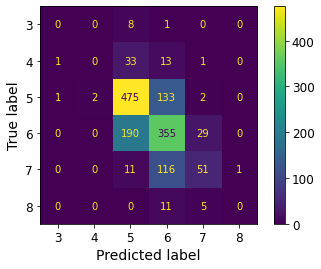

In [21]:
conf_matrix = confusion_matrix(y_train, ovr_scores_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=ovr_clf.classes_)
disp.plot()
plt.show()

### DecisionTree

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

dec_tree_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("dec_tree_clf", DecisionTreeClassifier(max_depth=13, random_state=2))
    ])
dec_tree_clf.fit(X_train, y_train) # Para obtener el atributo classes_

dec_tree_scores = cross_val_score(dec_tree_clf, X_train, y_train, cv=5)
dec_tree_scores_predicted = cross_val_predict(dec_tree_clf, X_train, y_train, cv=5)
display_scores(dec_tree_clf, dec_tree_scores, y_train, dec_tree_scores_predicted)

Scores: [0.58680556 0.59722222 0.57291667 0.61458333 0.57839721]
Mean Scores: 0.5899849980642664
Accuracy: 59.0 %
Mean Absolute Error: 0.4794996525364837
Mean Squared Error: 0.6337734537873523
Root Mean Squared Error: 0.7960988969891569
R2 Score: 0.027159256519244557
Standar Deviation: 0.014786271174034662
-------------------------
Precision:  0.5822081863522399
Recall:  0.5899930507296733
F1 Score:  0.5860061783565474


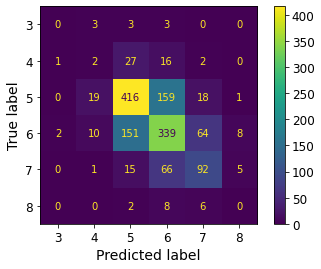

In [23]:
conf_matrix = confusion_matrix(y_train, dec_tree_scores_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dec_tree_clf.classes_)
disp.plot()
plt.show()

### RandomForest

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

rand_forest_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("rand_forest_clf", RandomForestClassifier(n_estimators=200, max_depth=10, random_state=2))
    ])
rand_forest_clf.fit(X_train, y_train) # Para obtener el atributo classes_

rand_forest_scores = cross_val_score(rand_forest_clf, X_train, y_train, cv=5)
rand_forest_scores_predicted = cross_val_predict(rand_forest_clf, X_train, y_train, cv=5)
display_scores(rand_forest_clf, rand_forest_scores, y_train, rand_forest_scores_predicted)

Scores: [0.66666667 0.65625    0.64236111 0.67361111 0.6445993 ]
Mean Scores: 0.6566976384049555
Accuracy: 65.67 %
Mean Absolute Error: 0.3766504517025712
Mean Squared Error: 0.4475330090340514
Root Mean Squared Error: 0.6689790796684537
R2 Score: 0.31303789605087007
Standar Deviation: 0.01214539579211935
-------------------------
Precision:  0.6230171027081481
Recall:  0.6567060458651841
F1 Score:  0.6348327748078061


C:\Users\gameo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


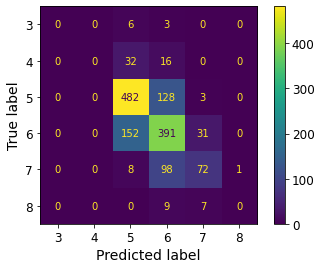

In [25]:
conf_matrix = confusion_matrix(y_train, rand_forest_scores_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rand_forest_clf.classes_)
disp.plot()
plt.show()

### KNeightborsClassifier

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

knn_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("knn_clf", KNeighborsClassifier(weights='distance', n_neighbors=5))
    ])
knn_clf.fit(X_train, y_train) # Para obtener el atributo classes_

knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=5)
knn_scores_predicted = cross_val_predict(knn_clf, X_train, y_train, cv=5)
display_scores(knn_clf, knn_scores, y_train, knn_scores_predicted)

Scores: [0.64930556 0.63541667 0.64930556 0.64236111 0.60627178]
Mean Scores: 0.6365321331784747
Accuracy: 63.65 %
Mean Absolute Error: 0.40514246004169563
Mean Squared Error: 0.4927032661570535
Root Mean Squared Error: 0.7019282485817575
R2 Score: 0.24370165885103545
Standar Deviation: 0.0159826846528487
-------------------------
Precision:  0.619084189570723
Recall:  0.6365531619179986
F1 Score:  0.6247626421915145


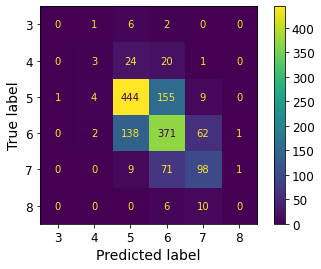

In [27]:
conf_matrix = confusion_matrix(y_train, knn_scores_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=knn_clf.classes_)
disp.plot()
plt.show()

## Comparativa del desempeño de los modelos

In [28]:
pd.DataFrame(
    {
        'SGDClassifier':{'Accuracy': sgdc_scores.mean(), 'Precision': precision_score(y_train, sgdc_scores_predicted, average=average_value), 'Recall': recall_score(y_train, sgdc_scores_predicted, average=average_value)},
        'SVC con kernel polinomial de grado 3':{'Accuracy': poly3_scores.mean(), 'Precision': precision_score(y_train, poly3_scores_predicted, average=average_value), 'Recall': recall_score(y_train, poly3_scores_predicted, average=average_value)},
        'SVC con kernel polinomial de grado 5':{'Accuracy': poly5_scores.mean(), 'Precision': precision_score(y_train, poly5_scores_predicted, average=average_value), 'Recall': recall_score(y_train, poly5_scores_predicted, average=average_value)},
        'SVC con kernel RBF':{'Accuracy': rbf_scores.mean(), 'Precision': precision_score(y_train, rbf_scores_predicted, average=average_value), 'Recall': recall_score(y_train, rbf_scores_predicted, average=average_value)},
        'OneVsRestClassifier':{'Accuracy': ovr_scores.mean(), 'Precision': precision_score(y_train, ovr_scores_predicted, average=average_value), 'Recall': recall_score(y_train, ovr_scores_predicted, average=average_value)},
        'DecisionTree': {'Accuracy': dec_tree_scores.mean(), 'Precision': precision_score(y_train, dec_tree_scores_predicted, average=average_value), 'Recall': recall_score(y_train, dec_tree_scores_predicted, average=average_value)},
        'RandomForest': {'Accuracy': rand_forest_scores.mean(), 'Precision': precision_score(y_train, rand_forest_scores_predicted, average=average_value), 'Recall': recall_score(y_train, rand_forest_scores_predicted, average=average_value)},
        'KnnClassifier': {'Accuracy': knn_scores.mean(), 'Precision': precision_score(y_train, knn_scores_predicted, average=average_value), 'Recall': recall_score(y_train, knn_scores_predicted, average=average_value)},
    }
).T

C:\Users\gameo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gameo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,Precision,Recall
SGDClassifier,0.551759,0.467645,0.553857
SVC con kernel polinomial de grado 3,0.571218,0.580282,0.571230
SVC con kernel polinomial de grado 5,0.587858,0.599481,0.587908
SVC con kernel RBF,0.598343,0.568259,0.598332
OneVsRestClassifier,0.612239,0.579430,0.612231
DecisionTree,0.589985,0.582208,0.589993
RandomForest,0.656698,0.623017,0.656706
KnnClassifier,0.636532,0.619084,0.636553


Para continuar se eliguen los dos modelos que arrojaron una mejor precisión para mejorar su rendimiento por medio de GridSearch. Estos modelos son:
- RandomForest con 65.66%
- KnnClassifier con 63.65%

También se tomó en cuenta para esta elección las matrices de confución. En el caso de ambos modelos las matrices presentan una diagonal mayormente amarilla con bordes apegados a esta. Lo que quiere decir que son mejores al clasificar "verdaderos positivos".

## Tuneando los parámetros 

### RandomForest

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

param_grid = [{
    'n_estimators': [200], 
    'max_depth': [10], 
    'random_state': [2]
}]
    
grid_rand_forest_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

grid_rand_forest_search.fit(X_train_scaled, y_train)
print('Mejores parámetros encontrados: '+str(grid_rand_forest_search.best_params_))

grid_rand_forest_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("rand_forest_clf", grid_rand_forest_search.best_estimator_)
    ])
grid_rand_forest_clf.fit(X_train, y_train)
grid_rand_forest_clf.score(X_test, y_test)

rand_forest_predicted_y = grid_rand_forest_clf.predict(X_test)
print(classification_report(y_test, rand_forest_predicted_y))

Mejores parámetros encontrados: {'max_depth': 10, 'n_estimators': 200, 'random_state': 2}
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         5
           5       0.74      0.82      0.78        68
           6       0.69      0.75      0.72        64
           7       0.93      0.65      0.76        20
           8       0.00      0.00      0.00         2

    accuracy                           0.73       160
   macro avg       0.39      0.37      0.38       160
weighted avg       0.70      0.73      0.71       160



C:\Users\gameo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gameo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gameo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### KnnClassifier

In [31]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

param_grid = [{
    'weights': ['distance'],
    'n_neighbors': [5]
}]
    
grid_knn_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

grid_knn_search.fit(X_train_scaled, y_train)
print('Mejores parámetros encontrados: '+str(grid_knn_search.best_params_))

grid_knn_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svc_clf", grid_knn_search.best_estimator_)
    ])
grid_knn_clf.fit(X_train, y_train)
grid_knn_clf.score(X_test, y_test)

knn_predicted_y = grid_knn_clf.predict(X_test)
print(classification_report(y_test, knn_predicted_y))

Mejores parámetros encontrados: {'n_neighbors': 5, 'weights': 'distance'}
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         5
           5       0.80      0.82      0.81        68
           6       0.70      0.73      0.72        64
           7       0.71      0.75      0.73        20
           8       1.00      0.50      0.67         2

    accuracy                           0.74       160
   macro avg       0.54      0.47      0.49       160
weighted avg       0.72      0.74      0.73       160



C:\Users\gameo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gameo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gameo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
